In [1]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
import subprocess
print(subprocess.getoutput('nvidia-smi'))

Fri Feb 12 05:12:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import copy

# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM


In [3]:
#Load model
!gdown --id 1N8K25e11VjTla_yDX4Xm37e7UtRNrM-2

#Load model_bonus
!gdown --id 1XKP37-huD9NVmD78Ts80oZ9-8HCnDuDa

Downloading...
From: https://drive.google.com/uc?id=1N8K25e11VjTla_yDX4Xm37e7UtRNrM-2
To: /content/best_model.h5
100% 928k/928k [00:00<00:00, 14.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1XKP37-huD9NVmD78Ts80oZ9-8HCnDuDa
To: /content/best_model_bonus.h5
100% 1.20M/1.20M [00:00<00:00, 18.9MB/s]


#Pipeline

In [4]:
#BI file
!gdown --id "1RpnQj8bcddT0cLbPmIB9vUGxSg9HfVHL"

# if not os.path.isfile("/content/compressor.xlsx.zip"):
!unzip /content/compressor.xlsx.zip


Downloading...
From: https://drive.google.com/uc?id=1RpnQj8bcddT0cLbPmIB9vUGxSg9HfVHL
To: /content/compressor.xlsx.zip
10.4MB [00:00, 91.5MB/s]
Archive:  /content/compressor.xlsx.zip
  inflating: compressor.xlsx         
  inflating: __MACOSX/._compressor.xlsx  


In [5]:
df = pd.read_excel('/content/compressor.xlsx')
df = df[21171:]

In [6]:
#motor left and right gang
motor_wing = [
'TI3108111.PV'
,'TI3108113.PV'
,'TI3108114.PV'
,'TI3108115.PV'
,'TI3108116.PV'
,'TI3108119.PV'
,'TI3108131.PV'
,'TI3108132.PV'
]

In [7]:
df_test = df #excel from BI
df_test['id']=1

df_test = df_test[
(df['VI3108101X.PV'] >= 6) &
(df['VI3108101Y.PV'] >= 6) &
(df['VI3108102X.PV'] >= 6) &
(df['VI3108102Y.PV'] >= 6) &
(df['VI3108131X.PV'] >= 6) &
(df['VI3108131Y.PV'] >= 6) &
(df['VI3108132X.PV'] >= 6) &
(df['VI3108132Y.PV'] >= 6) &
(df['VI3108151X.PV'] >= 6) &
(df['VI3108151Y.PV'] >= 6) &
(df['VI3108152X.PV'] >= 6) &
(df['VI3108152Y.PV'] >= 6) &
(df['VI3108161X.PV'] >= 6) &
(df['VI3108161Y.PV'] >= 6) &
(df['VI3108162X.PV'] >= 6) &
(df['VI3108162Y.PV'] >= 6)
]
df_test = df_test[['date','id']+motor_wing]

# mask = (df_test['date'] > '2019-07-19 04:00:00	') & (df_test['date'] <= '2020-03-04 23:00:00')
# df_test = df_test.loc[mask]

# df_test[['date']+motor_wing].plot(x="date", kind="line", figsize=(20,8))



In [8]:
def pipeline(df_test):

  # MinMax normalization (from 0 to 1)

  cols_normalize = df_test.columns.difference(['date','id'])

  min_max_scaler = preprocessing.MinMaxScaler()
  norm_df = pd.DataFrame(min_max_scaler.fit_transform(df_test[cols_normalize]), 
                              columns=cols_normalize, 
                              index=df_test.index)
  join_df = df_test[df_test.columns.difference(cols_normalize)].join(norm_df)
  df_test = join_df.reindex(columns = df_test.columns)


  # function to reshape features into (samples, time steps, features) 
  def gen_sequence(id_df, seq_length, seq_cols):

      # for one id I put all the rows in a single matrix
      data_matrix = id_df[seq_cols].values
      num_elements = data_matrix.shape[0]

      for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
          yield data_matrix[start:stop, :]


  sequence_cols = motor_wing
  sequence_length = 50

  # generator for the sequences
  seq_gen = (list(gen_sequence(df_test[df_test['id']==id], sequence_length, sequence_cols)) 
            for id in df_test['id'].unique())
  # generate sequences and convert to numpy array
  seq_array_test = np.concatenate(list(seq_gen)).astype(np.float32)
  # print("sequence")
  # print(seq_array_test.shape)
  # print(seq_array_test)

  # if best iteration's model was saved then load and use it
  model_path = '/content/best_model.h5'
  if os.path.isfile(model_path):
    model = load_model(model_path)

  y_pred = model.predict_classes(seq_array_test,verbose=1, batch_size=200)
  # y_pred_bonus = model_bonus.predict_classes(seq_array_test,verbose=1, batch_size=200)
  #save result
  temp = pd.DataFrame(y_pred)
  temp.to_csv('binary_submit_train.csv', index = None)

  # Plot in red color the predicted data
  # actual data to verify visually the accuracy of the model.
  fig_verify = plt.figure(figsize=(10, 5))
  plt.plot(y_pred, color="red")
  plt.title('prediction')
  plt.ylabel('value')
  plt.xlabel('row')
  plt.legend(['predicted'], loc='upper left')
  plt.show()
  fig_verify.savefig("model_verify.png")

  return y_pred

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


20/20 [==============================] - 7s 6ms/step


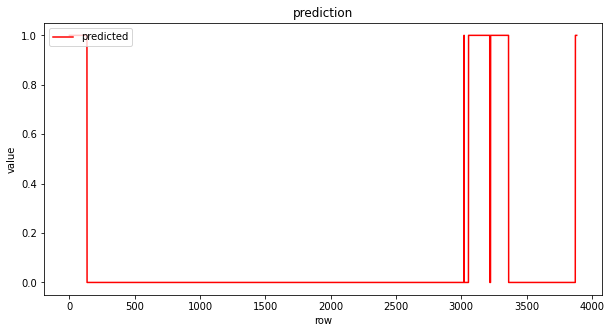

In [9]:
prediction = pipeline(df_test)

In [10]:
pred_list = []
for x in prediction:
  pred_list.append(x[0])
len(prediction)


3885

In [11]:
pred_date = df_test[50:]#clean slicing window
pred_date['predict'] = pred_list#new column
pred_date = pred_date[['date','predict']]
pred_date["date"] = pd.to_datetime(pred_date ["date"])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


###visualize

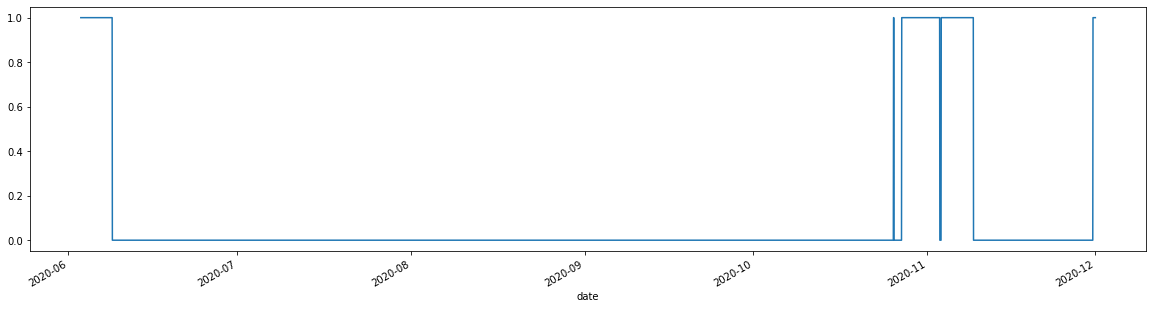

In [12]:
mask = (pred_date['date'] > '2017-05-01 04:00:00	') & (pred_date['date'] <= '2022-05-25 23:00:00')
pred_date_temp = pred_date.loc[mask]

fig_verify = plt.figure(figsize=(20, 5))
pred_date_temp = pred_date_temp.set_index('date')
lines = pred_date_temp['predict'].plot.line()


###Por's code

In [13]:
import datetime 

notify = list()
for idx, row in pred_date.iterrows():
    if row["predict"] == 1:
        notify.append(row["date"])

notify_before_seven_days = [notify[0].to_pydatetime()]
out = list()
out.append(notify[0].to_pydatetime())

last_alert = notify[0].to_pydatetime()
cnt = 0
cnt_out = list()
for n in notify:
    if (n.to_pydatetime() - last_alert).total_seconds() > 86400:
        out.append(n.to_pydatetime())
        notify_before_seven_days.append(n.to_pydatetime() - datetime.timedelta(days=7))
        last_alert = n.to_pydatetime()
        cnt_out.append(cnt)
        cnt = 0
    else:
        cnt += 1
        last_alert = n.to_pydatetime()
cnt_out.append(cnt)

date_final2 = notify_before_seven_days[np.argmax(cnt_out)].strftime("%m/%d/%Y %H:%M:%S")
date_final = out[np.argmax(cnt_out)].strftime("%m/%d/%Y %H:%M:%S")

###Report

In [14]:
!pip install pyfiglet

     |████████████████████████████████| 870kB 14.7MB/s 


In [15]:
#edit ascii
import pyfiglet
ascii_banner = pyfiglet.figlet_format("Report !")
ascii_sensor = pyfiglet.figlet_format("Sensor Detect !")

In [16]:
#title
print(ascii_banner)

print(

"╔═══════════╦═════════════════════╗\n"
"║   Type    ║        Date         ║\n"
"╠═══════════╬═════════════════════╣\n"
"║ predicted ║ {} ║\n"
# "║           ║                      "
"╚═══════════╩═════════════════════╝\n".format(date_final)
)

# print('The predicted date for anomaly is')
# print(date_final)
# print('\n')

# print('The notify date for anomaly is')
# print(date_final2)

# print('Sensors Detect')
print(ascii_sensor)
print(motor_wing)

 ____                       _     _ 
|  _ \ ___ _ __   ___  _ __| |_  | |
| |_) / _ \ '_ \ / _ \| '__| __| | |
|  _ <  __/ |_) | (_) | |  | |_  |_|
|_| \_\___| .__/ \___/|_|   \__| (_)
          |_|                       

╔═══════════╦═════════════════════╗
║   Type    ║        Date         ║
╠═══════════╬═════════════════════╣
║ predicted ║ 10/27/2020 12:00:00 ║
╚═══════════╩═════════════════════╝

 ____                              ____       _            _     _ 
/ ___|  ___ _ __  ___  ___  _ __  |  _ \  ___| |_ ___  ___| |_  | |
\___ \ / _ \ '_ \/ __|/ _ \| '__| | | | |/ _ \ __/ _ \/ __| __| | |
 ___) |  __/ | | \__ \ (_) | |    | |_| |  __/ ||  __/ (__| |_  |_|
|____/ \___|_| |_|___/\___/|_|    |____/ \___|\__\___|\___|\__| (_)
                                                                   

['TI3108111.PV', 'TI3108113.PV', 'TI3108114.PV', 'TI3108115.PV', 'TI3108116.PV', 'TI3108119.PV', 'TI3108131.PV', 'TI3108132.PV']


#Bonus

#Pipeline

In [17]:
#BI file
# !gdown --id "1RpnQj8bcddT0cLbPmIB9vUGxSg9HfVHL"

# # if not os.path.isfile("/content/compressor.xlsx.zip"):
# !unzip /content/compressor.xlsx.zip

In [18]:
df = pd.read_excel('/content/compressor.xlsx')
df = df[21171:]

In [19]:
df

,date,FIC3104801.OP,FIC3104801.PV,FIC3104901.OP,FIC3104901.PV,FIC3105201.OP,FIC3105201.PV,JI3104901.PV,LI3104702.PV,LIC3105201.OP,LIC3105201.PV,LIC3105204.OP,LIC3105204.PV,PI3100508.PV,PI3104801.PV,PI3104803.PV,PI3104903.PV,PI3104905.PV,PIC3104701.OP,PIC3104701.PV,PIC3104901.OP,SI3104901.PV,TI3104801.PV,TI3104802.PV,TI3104901.PV,TI3104902.PV,TI3105203.PV,TI3105301.PV,TI3108102.PV,TI3108104.PV,TI3108105.PV,TI3108106.PV,TI3108107.PV,TI3108108.PV,TI3108111.PV,TI3108113.PV,TI3108114.PV,TI3108115.PV,TI3108116.PV,TI3108119.PV,TI3108131.PV,TI3108132.PV,TI3108134.PV,TI3108135.PV,TI3108136.PV,VI3108101X.PV,VI3108101Y.PV,VI3108102X.PV,VI3108102Y.PV,VI3108131X.PV,VI3108131Y.PV,VI3108132X.PV,VI3108132Y.PV,VI3108151X.PV,VI3108151Y.PV,VI3108152X.PV,VI3108152Y.PV,VI3108161X.PV,VI3108161Y.PV,VI3108162X.PV,VI3108162Y.PV,ZI3108105A.PV,ZI3108105B.PV,ZI3108155A.PV,ZI3108155B.PV
21171,2020-06-01 03:00:00,0.0,41177.52,0.0,36537.09,45.42,9.54,5031.13,3.96,53.02,20.02,0.57,37.01,0.70,4.25,0.33,3.70,16.07,-6.9,0.38,86.84,6201.44,106.80,39.19,121.03,43.26,42.68,58.94,60.99,61.00,64.71,62.97,82.97,83.99,64.98,64.98,54.67,59.98,66.99,62.97,59.00,80.00,93.00,91.97,93.97,13.37,10.29,19.86,41.03,12.84,12.80,15.53,30.38,18.92,21.93,10.42,16.29,9.93,11.23,18.55,16.67,0.28,0.30,-0.15,-0.14
21172,2020-06-01 04:00:00,0.0,41191.54,0.0,36547.06,45.33,9.53,5029.01,6.13,52.94,20.00,0.66,37.01,0.70,4.25,0.33,3.70,16.06,-6.9,0.38,86.84,6201.11,106.88,39.28,121.06,43.32,42.73,58.92,60.99,61.50,64.79,62.97,82.98,83.99,64.98,64.98,54.94,60.00,66.99,63.02,59.00,80.00,93.41,91.97,93.97,13.74,10.32,20.00,41.74,12.93,12.88,15.58,30.45,18.91,22.01,10.45,16.35,9.96,11.20,18.55,16.90,0.28,0.30,-0.15,-0.14
21173,2020-06-01 05:00:00,0.0,41180.14,0.0,36554.75,45.32,9.51,5029.76,8.30,52.84,19.98,0.55,36.99,0.70,4.25,0.33,3.70,16.07,-6.9,0.38,86.84,6201.20,106.94,39.37,121.11,43.38,42.76,59.02,60.99,61.50,64.88,62.97,82.97,83.99,64.98,64.98,54.89,59.98,66.99,63.22,59.00,80.00,93.97,92.39,94.89,13.81,10.36,20.03,41.62,12.94,12.89,15.62,30.50,18.85,22.01,10.52,16.32,9.93,11.32,18.59,16.75,0.28,0.30,-0.16,-0.14
21174,2020-06-01 06:00:00,0.0,41151.06,0.0,36557.50,45.25,9.48,5022.81,5.06,52.69,19.98,0.60,37.01,0.70,4.25,0.33,3.70,16.09,-6.9,0.38,86.84,6201.08,106.95,39.35,121.11,43.35,42.71,58.99,60.99,60.99,64.38,62.97,82.97,83.99,64.98,64.98,54.02,59.24,66.99,62.97,59.00,80.00,93.97,93.00,95.00,13.78,10.35,19.96,41.58,13.03,12.91,15.61,30.53,18.91,22.06,10.44,16.28,9.94,11.22,18.51,16.77,0.28,0.30,-0.15,-0.14
21175,2020-06-01 07:00:00,0.0,41139.56,0.0,36598.41,44.96,9.36,5033.36,5.03,52.03,19.98,0.58,37.00,0.70,4.25,0.33,3.70,16.11,-6.9,0.38,86.84,6201.31,106.99,39.42,121.05,43.32,42.77,59.36,60.99,60.99,64.24,62.97,82.97,83.99,64.98,64.98,54.04,59.36,66.99,62.97,58.77,80.00,93.97,93.00,95.00,13.77,10.37,19.94,41.63,12.99,12.94,15.66,30.61,18.99,22.09,10.53,16.39,9.95,11.26,18.60,16.75,0.28,0.30,-0.15,-0.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25556,2020-11-30 20:00:00,13.0,36769.32,12.0,34794.16,47.30,10.69,4501.18,7.60,59.42,20.08,28.74,32.99,0.70,4.20,0.38,3.65,14.25,-6.9,0.43,83.44,6013.10,104.58,38.64,111.81,39.74,39.69,59.42,58.97,58.97,62.95,60.99,83.19,84.01,62.97,62.97,52.24,57.98,64.98,60.99,57.98,77.59,84.98,83.96,85.96,12.86,8.83,17.37,37.40,12.45,12.91,13.86,27.55,19.02,22.77,10.49,15.79,9.19,10.32,18.77,16.54,0.30,0.32,-0.15,-0.13
25557,2020-11-30 21:00:00,13.0,37016.99,12.0,35061.49,48.20,10.87,4516.76,3.96,60.43,20.03,28.79,32.99,0.71,4.23,0.39,3.67,14.29,-6.9,0.44,83.43,6013.07,104.56,38.61,111.76,39.73,39.70,59.39,58.97,58.97,62.29,60.99,83.40,84.16,62.97,62.97,51.98,57.97,64.98,60.99,57.98,77.11,85.25,83.96,85.96,12.85,8.81,17.38,37.35,12.46,12.90,13.94,27.59,19.07,22.75,10.45,15.75,9.18,10.34,18.80,16.49,0.30,0.32,-0.15,-0.13
25558,2020-11-30 

In [20]:
df_test = df #excel from BI
df_test['id']=1

df_test = df_test[
(df['VI3108101X.PV'] >= 6) &
(df['VI3108101Y.PV'] >= 6) &
(df['VI3108102X.PV'] >= 6) &
(df['VI3108102Y.PV'] >= 6) &
(df['VI3108131X.PV'] >= 6) &
(df['VI3108131Y.PV'] >= 6) &
(df['VI3108132X.PV'] >= 6) &
(df['VI3108132Y.PV'] >= 6) &
(df['VI3108151X.PV'] >= 6) &
(df['VI3108151Y.PV'] >= 6) &
(df['VI3108152X.PV'] >= 6) &
(df['VI3108152Y.PV'] >= 6) &
(df['VI3108161X.PV'] >= 6) &
(df['VI3108161Y.PV'] >= 6) &
(df['VI3108162X.PV'] >= 6) &
(df['VI3108162Y.PV'] >= 6)
]

In [21]:
df_test

,date,FIC3104801.OP,FIC3104801.PV,FIC3104901.OP,FIC3104901.PV,FIC3105201.OP,FIC3105201.PV,JI3104901.PV,LI3104702.PV,LIC3105201.OP,LIC3105201.PV,LIC3105204.OP,LIC3105204.PV,PI3100508.PV,PI3104801.PV,PI3104803.PV,PI3104903.PV,PI3104905.PV,PIC3104701.OP,PIC3104701.PV,PIC3104901.OP,SI3104901.PV,TI3104801.PV,TI3104802.PV,TI3104901.PV,TI3104902.PV,TI3105203.PV,TI3105301.PV,TI3108102.PV,TI3108104.PV,TI3108105.PV,TI3108106.PV,TI3108107.PV,TI3108108.PV,TI3108111.PV,TI3108113.PV,TI3108114.PV,TI3108115.PV,TI3108116.PV,TI3108119.PV,TI3108131.PV,TI3108132.PV,TI3108134.PV,TI3108135.PV,TI3108136.PV,VI3108101X.PV,VI3108101Y.PV,VI3108102X.PV,VI3108102Y.PV,VI3108131X.PV,VI3108131Y.PV,VI3108132X.PV,VI3108132Y.PV,VI3108151X.PV,VI3108151Y.PV,VI3108152X.PV,VI3108152Y.PV,VI3108161X.PV,VI3108161Y.PV,VI3108162X.PV,VI3108162Y.PV,ZI3108105A.PV,ZI3108105B.PV,ZI3108155A.PV,ZI3108155B.PV,id
21171,2020-06-01 03:00:00,0.0,41177.52,0.0,36537.09,45.42,9.54,5031.13,3.96,53.02,20.02,0.57,37.01,0.70,4.25,0.33,3.70,16.07,-6.9,0.38,86.84,6201.44,106.80,39.19,121.03,43.26,42.68,58.94,60.99,61.00,64.71,62.97,82.97,83.99,64.98,64.98,54.67,59.98,66.99,62.97,59.00,80.00,93.00,91.97,93.97,13.37,10.29,19.86,41.03,12.84,12.80,15.53,30.38,18.92,21.93,10.42,16.29,9.93,11.23,18.55,16.67,0.28,0.30,-0.15,-0.14,1
21172,2020-06-01 04:00:00,0.0,41191.54,0.0,36547.06,45.33,9.53,5029.01,6.13,52.94,20.00,0.66,37.01,0.70,4.25,0.33,3.70,16.06,-6.9,0.38,86.84,6201.11,106.88,39.28,121.06,43.32,42.73,58.92,60.99,61.50,64.79,62.97,82.98,83.99,64.98,64.98,54.94,60.00,66.99,63.02,59.00,80.00,93.41,91.97,93.97,13.74,10.32,20.00,41.74,12.93,12.88,15.58,30.45,18.91,22.01,10.45,16.35,9.96,11.20,18.55,16.90,0.28,0.30,-0.15,-0.14,1
21173,2020-06-01 05:00:00,0.0,41180.14,0.0,36554.75,45.32,9.51,5029.76,8.30,52.84,19.98,0.55,36.99,0.70,4.25,0.33,3.70,16.07,-6.9,0.38,86.84,6201.20,106.94,39.37,121.11,43.38,42.76,59.02,60.99,61.50,64.88,62.97,82.97,83.99,64.98,64.98,54.89,59.98,66.99,63.22,59.00,80.00,93.97,92.39,94.89,13.81,10.36,20.03,41.62,12.94,12.89,15.62,30.50,18.85,22.01,10.52,16.32,9.93,11.32,18.59,16.75,0.28,0.30,-0.16,-0.14,1
21174,2020-06-01 06:00:00,0.0,41151.06,0.0,36557.50,45.25,9.48,5022.81,5.06,52.69,19.98,0.60,37.01,0.70,4.25,0.33,3.70,16.09,-6.9,0.38,86.84,6201.08,106.95,39.35,121.11,43.35,42.71,58.99,60.99,60.99,64.38,62.97,82.97,83.99,64.98,64.98,54.02,59.24,66.99,62.97,59.00,80.00,93.97,93.00,95.00,13.78,10.35,19.96,41.58,13.03,12.91,15.61,30.53,18.91,22.06,10.44,16.28,9.94,11.22,18.51,16.77,0.28,0.30,-0.15,-0.14,1
21175,2020-06-01 07:00:00,0.0,41139.56,0.0,36598.41,44.96,9.36,5033.36,5.03,52.03,19.98,0.58,37.00,0.70,4.25,0.33,3.70,16.11,-6.9,0.38,86.84,6201.31,106.99,39.42,121.05,43.32,42.77,59.36,60.99,60.99,64.24,62.97,82.97,83.99,64.98,64.98,54.04,59.36,66.99,62.97,58.77,80.00,93.97,93.00,95.00,13.77,10.37,19.94,41.63,12.99,12.94,15.66,30.61,18.99,22.09,10.53,16.39,9.95,11.26,18.60,16.75,0.28,0.30,-0.15,-0.14,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25556,2020-11-30 20:00:00,13.0,36769.32,12.0,34794.16,47.30,10.69,4501.18,7.60,59.42,20.08,28.74,32.99,0.70,4.20,0.38,3.65,14.25,-6.9,0.43,83.44,6013.10,104.58,38.64,111.81,39.74,39.69,59.42,58.97,58.97,62.95,60.99,83.19,84.01,62.97,62.97,52.24,57.98,64.98,60.99,57.98,77.59,84.98,83.96,85.96,12.86,8.83,17.37,37.40,12.45,12.91,13.86,27.55,19.02,22.77,10.49,15.79,9.19,10.32,18.77,16.54,0.30,0.32,-0.15,-0.13,1
25557,2020-11-30 21:00:00,13.0,37016.99,12.0,35061.49,48.20,10.87,4516.76,3.96,60.43,20.03,28.79,32.99,0.71,4.23,0.39,3.67,14.29,-6.9,0.44,83.43,6013.07,104.56,38.61,111.76,39.73,39.70,59.39,58.97,58.97,62.29,60.99,83.40,84.16,62.97,62.97,51.98,57.97,64.98,60.99,57.98,77.11,85.25,83.96,85.96,12.85,8.81,17.38,37.35,12.46,12.90,13.94,27.59,19.07,22.75,10.45,15.75,9.18,10.34,18.80,16.49,0.30,0.32,-0.15,-0.1

In [22]:
def pipeline(df_test):

  # MinMax normalization (from 0 to 1)

  cols_normalize = df_test.columns.difference(['date','id'])

  min_max_scaler = preprocessing.MinMaxScaler()
  norm_df = pd.DataFrame(min_max_scaler.fit_transform(df_test[cols_normalize]), 
                              columns=cols_normalize, 
                              index=df_test.index)
  join_df = df_test[df_test.columns.difference(cols_normalize)].join(norm_df)
  df_test = join_df.reindex(columns = df_test.columns)


  # function to reshape features into (samples, time steps, features) 
  def gen_sequence(id_df, seq_length, seq_cols):

      # for one id I put all the rows in a single matrix
      data_matrix = id_df[seq_cols].values
      num_elements = data_matrix.shape[0]

      for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
          yield data_matrix[start:stop, :]


  sequence_cols = [
        'FIC3104801.OP', 'FIC3104801.PV', 'FIC3104901.OP',
        'FIC3104901.PV', 'FIC3105201.OP', 'FIC3105201.PV', 'JI3104901.PV',
        'LI3104702.PV', 'LIC3105201.OP', 'LIC3105201.PV', 'LIC3105204.OP',
        'LIC3105204.PV', 'PI3100508.PV', 'PI3104801.PV', 'PI3104803.PV',
        'PI3104903.PV', 'PI3104905.PV', 'PIC3104701.OP', 'PIC3104701.PV',
        'PIC3104901.OP', 'SI3104901.PV', 'TI3104801.PV', 'TI3104802.PV',
        'TI3104901.PV', 'TI3104902.PV', 'TI3105203.PV', 'TI3105301.PV',
        'TI3108102.PV', 'TI3108104.PV', 'TI3108105.PV', 'TI3108106.PV',
        'TI3108107.PV', 'TI3108108.PV', 'TI3108111.PV', 'TI3108113.PV',
        'TI3108114.PV', 'TI3108115.PV', 'TI3108116.PV', 'TI3108119.PV',
        'TI3108131.PV', 'TI3108132.PV', 'TI3108134.PV', 'TI3108135.PV',
        'TI3108136.PV', 'VI3108101X.PV', 'VI3108101Y.PV', 'VI3108102X.PV',
        'VI3108102Y.PV', 'VI3108131X.PV', 'VI3108131Y.PV', 'VI3108132X.PV',
        'VI3108132Y.PV', 'VI3108151X.PV', 'VI3108151Y.PV', 'VI3108152X.PV',
        'VI3108152Y.PV', 'VI3108161X.PV', 'VI3108161Y.PV', 'VI3108162X.PV',
        'VI3108162Y.PV', 'ZI3108105A.PV', 'ZI3108105B.PV', 'ZI3108155A.PV',
        'ZI3108155B.PV'
                
  ]

  sequence_length = 50

  # generator for the sequences
  seq_gen = (list(gen_sequence(df_test[df_test['id']==id], sequence_length, sequence_cols)) 
            for id in df_test['id'].unique())
  # generate sequences and convert to numpy array
  seq_array_test = np.concatenate(list(seq_gen)).astype(np.float32)
  print("sequence")
  print(seq_array_test.shape)
  print(seq_array_test)



  # if best iteration's model was saved then load and use it
  model_path_bonus = '/content/best_model_bonus.h5'
  if os.path.isfile(model_path_bonus):
    model_bonus = load_model(model_path_bonus)


  # seq_array_test.resize(seq_array_test.shape[0],seq_array_test.shape[1],1)

  y_pred_bonus = model_bonus.predict_classes(seq_array_test,verbose=1, batch_size=200)


  #save result
  temp = pd.DataFrame(y_pred_bonus)
  temp.to_csv('binary_submit_train.csv', index = None)

  # Plot in red color the predicted data
  # actual data to verify visually the accuracy of the model.
  fig_verify = plt.figure(figsize=(10, 5))
  plt.plot(y_pred_bonus, color="red")
  plt.title('prediction')
  plt.ylabel('value')
  plt.xlabel('row')
  plt.legend(['predicted'], loc='upper left')
  plt.show()
  fig_verify.savefig("model_verify.png")

  return y_pred_bonus

sequence
(3885, 50, 64)
[[[0.         0.7746405  0.         ... 0.85714287 1.         0.5       ]
  [0.         0.77530485 0.         ... 0.85714287 1.         0.5       ]
  [0.         0.77476466 0.         ... 0.85714287 0.5        0.5       ]
  ...
  [0.0586     0.55306    0.1105     ... 0.9285714  0.5        0.5       ]
  [0.0586     0.5548692  0.1105     ... 0.9285714  0.5        0.5       ]
  [0.0586     0.55059355 0.1105     ... 0.9285714  1.         0.5       ]]

 [[0.         0.77530485 0.         ... 0.85714287 1.         0.5       ]
  [0.         0.77476466 0.         ... 0.85714287 0.5        0.5       ]
  [0.         0.77338666 0.         ... 0.85714287 1.         0.5       ]
  ...
  [0.0586     0.5548692  0.1105     ... 0.9285714  0.5        0.5       ]
  [0.0586     0.55059355 0.1105     ... 0.9285714  1.         0.5       ]
  [0.0586     0.5523942  0.1105     ... 0.9285714  1.         0.5       ]]

 [[0.         0.77476466 0.         ... 0.85714287 0.5        0.5       

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


20/20 [==============================] - 1s 7ms/step


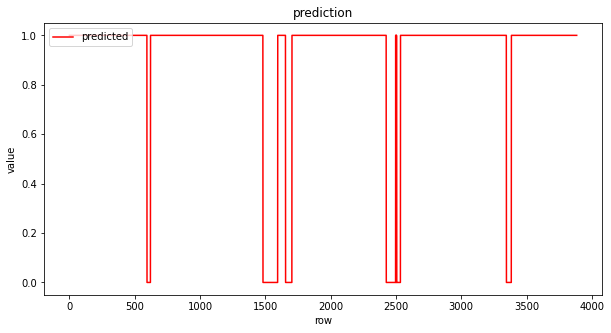

In [23]:
prediction_bonus = pipeline(df_test)

In [24]:
pred_list = []
for x in prediction_bonus:
  pred_list.append(x[0])
len(prediction)

3885

In [25]:
pred_date = df_test[50:]#clean slicing window
pred_date['predict'] = pred_list#new column
pred_date = pred_date[['date','predict']]
pred_date["date"] = pd.to_datetime(pred_date ["date"])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


###visualize

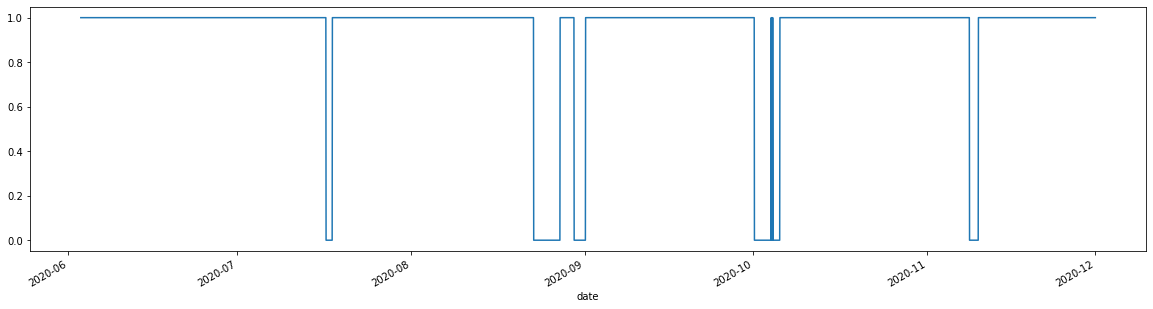

In [26]:
mask = (pred_date['date'] > '2017-05-01 04:00:00	') & (pred_date['date'] <= '2022-05-25 23:00:00')
pred_date_temp = pred_date.loc[mask]

fig_verify = plt.figure(figsize=(20, 5))
pred_date_temp = pred_date_temp.set_index('date')
lines = pred_date_temp['predict'].plot.line()


In [27]:
import datetime 

notify = list()
for idx, row in pred_date.iterrows():
    if row["predict"] == 1:
        notify.append(row["date"])

notify_before_seven_days = [notify[0].to_pydatetime()]
out = list()
out.append(notify[0].to_pydatetime())

last_alert = notify[0].to_pydatetime()
cnt = 0
cnt_out = list()
for n in notify:
    if (n.to_pydatetime() - last_alert).total_seconds() > 86400:
        out.append(n.to_pydatetime())
        notify_before_seven_days.append(n.to_pydatetime() - datetime.timedelta(days=7))
        last_alert = n.to_pydatetime()
        cnt_out.append(cnt)
        cnt = 0
    else:
        cnt += 1
        last_alert = n.to_pydatetime()
cnt_out.append(cnt)

# date_final = notify_before_seven_days[np.argmax(cnt_out)].strftime("%m/%d/%Y %H:%M:%S")

cnt_out_new = []
for idx,x in enumerate(cnt_out):
  if x<100:
    cnt_out_new.append(out[idx])

date_final_bonus = [x.strftime("%m/%d/%Y %H:%M:%S") for x in cnt_out_new]
# cnt_out_new = [i for i in cnt_out if i<100]


In [28]:
date_final_bonus

['07/15/2020 21:00:00', '08/27/2020 15:00:00', '10/04/2020 06:00:00']

###Report

In [29]:
print('The predicted date for bonus anomaly is')
print(date_final_bonus)
print('\n')


The predicted date for bonus anomaly is
['07/15/2020 21:00:00', '08/27/2020 15:00:00', '10/04/2020 06:00:00']


